<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/S_10_LRFinder_Misclassified_Cifar10/EVA4_S12_TinyImagenet_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


import sys,os
from pathlib import Path


homepath = Path('/content/drive/My Drive/pytorch_Framework_suman/')
sys.path.append(str(homepath))

sys.path.append(os.path.join(homepath,'lib'))
print(sys.path)

!ls

Mounted at /content/drive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/pytorch_Framework_suman', '/content/drive/My Drive/pytorch_Framework_suman/lib']
drive  sample_data  tiny-imagenet-200


# Download and Copy the tiny-Imagenet data set to colab

In [0]:
from zipfile import ZipFile 
from torchvision.datasets.utils import download_url

if not os.path.exists(os.path.join(homepath,'data/tinyImagenet/tiny-imagenet-200.zip')):
    # Dowload the dataset
    dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    download_url(dataset_url, os.path.join(homepath,'data','tinyImagenet'))

In [3]:
zip_path = os.path.join(homepath,'data/tinyImagenet/tiny-imagenet-200.zip')
print('tiny-dataset zip file path is at : {}'.format(zip_path))

if not os.path.exists(os.path.basename(zip_path).split('.zip')[0]):
    !cp "{zip_path}" .
    !unzip -q "{os.path.basename(zip_path)}"
    !rm "{os.path.basename(zip_path)}"

if os.getcwd() != '/content/tiny-imagenet-200':
    os.chdir(os.path.basename(zip_path).split('.zip')[0])
    !ls 

tiny-dataset zip file path is at : /content/drive/My Drive/pytorch_Framework_suman/data/tinyImagenet/tiny-imagenet-200.zip
metrics.png  test_set		train	   val	      words.txt
test	     tiny-imagenet-200	train_set  wnids.txt


# Split the dataset (train and validation) into 70% + 30%

In [0]:
from utils.splitDs import *

copyValDsIntoTrain()
splitDs()

# Initialize device

In [5]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


# Load train and validation dataset

In [0]:
os.chdir('/content/tiny-imagenet-200')

In [0]:
import torchvision
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

## Prepeare transformations

In [8]:
# Data transforms (normalization & data augmentation)
from lib.cutout import Cutout

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

tfmsList = []

tfmsList.append(
    tt.Compose([  tt.RandomCrop(56, padding=4, padding_mode='reflect'),
                  tt.RandomRotation(degrees=([-90,90]), resample=False, expand=False, center=None, fill=0),
                  tt.ToTensor(),
                  Cutout(n_holes=1, length=16),
                  tt.Normalize(*stats)
    ])
)

tfmsList.append(
    tt.Compose([  tt.ColorJitter(brightness=([0.7,1.3]), contrast=([0.7,1.3]), saturation=([0.7,1.3]), hue=0),
                  tt.RandomHorizontalFlip(p=0.5),
                  tt.ToTensor(), 
                  Cutout(n_holes=2, length=16),
                  tt.Normalize(*stats)
    ])
)
'''
tfmsList.append(
    tt.Compose([  tt.RandomRotation(degrees=([-90,90]), resample=False, expand=False, center=None, fill=0),
                  tt.ToTensor(), 
                  Cutout(n_holes=2, length=16),
                  tt.Normalize(*stats)
    ])
)


tfmsList.append(
    tt.Compose([  tt.ColorJitter(brightness=([0.7,1.3]), contrast=([0.7,1.3]), saturation=([0.7,1.3]), hue=0),
                  tt.ToTensor(), 
                  Cutout(n_holes=2, length=16),
                  tt.Normalize(*stats)
    ])
)
'''

#print(tfmsList)						 

'\ntfmsList.append(\n    tt.Compose([  tt.RandomRotation(degrees=([-90,90]), resample=False, expand=False, center=None, fill=0),\n                  tt.ToTensor(), \n                  Cutout(n_holes=2, length=16),\n                  tt.Normalize(*stats)\n    ])\n)\n\n\ntfmsList.append(\n    tt.Compose([  tt.ColorJitter(brightness=([0.7,1.3]), contrast=([0.7,1.3]), saturation=([0.7,1.3]), hue=0),\n                  tt.ToTensor(), \n                  Cutout(n_holes=2, length=16),\n                  tt.Normalize(*stats)\n    ])\n)\n'

In [0]:
import random

train_tfms = random.choice(tfmsList)
valid_tfms = tt.Compose([	#tt.CenterCrop(56),
							tt.ToTensor(),
							tt.Normalize(*stats)
						])

In [10]:
train_ds = ImageFolder('train_set', transform=train_tfms)
test_ds = ImageFolder('test_set', transform=train_tfms)

print("random item from list is: ",train_tfms)
print('####Validation Dataset is : \n\t\n{}'.format(train_ds))
print('####Validation Dataset is : \n\t\n{}'.format(test_ds))

random item from list is:  Compose(
    RandomCrop(size=(56, 56), padding=4)
    RandomRotation(degrees=[-90, 90], resample=False, expand=False)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
####Validation Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 77000
    Root location: train_set
    StandardTransform
Transform: Compose(
               RandomCrop(size=(56, 56), padding=4)
               RandomRotation(degrees=[-90, 90], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
####Validation Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 33000
    Root location: test_set
    StandardTransform
Transform: Compose(
               CenterCrop(size=(56, 56))
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


# Print few images from the train dataset

In [0]:
from matplotlib import pyplot as plt
def show_imgs(img,label):
    print('Image label is : {}'.format(train_ds.classes[label]))
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image label is : n01443537


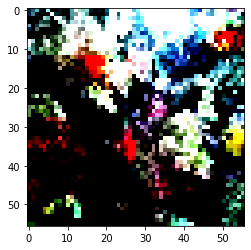

In [12]:
show_imgs(*test_ds[8])

# Print few images from the train dataloader and test data loader

In [0]:
from torch.utils.data import DataLoader
batch_size = 512

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl,numOfImagesToDisplay=10,imgsPerRow=5):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 26))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:numOfImagesToDisplay], imgsPerRow).permute(1, 2, 0))
        break

Print few images from Train DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


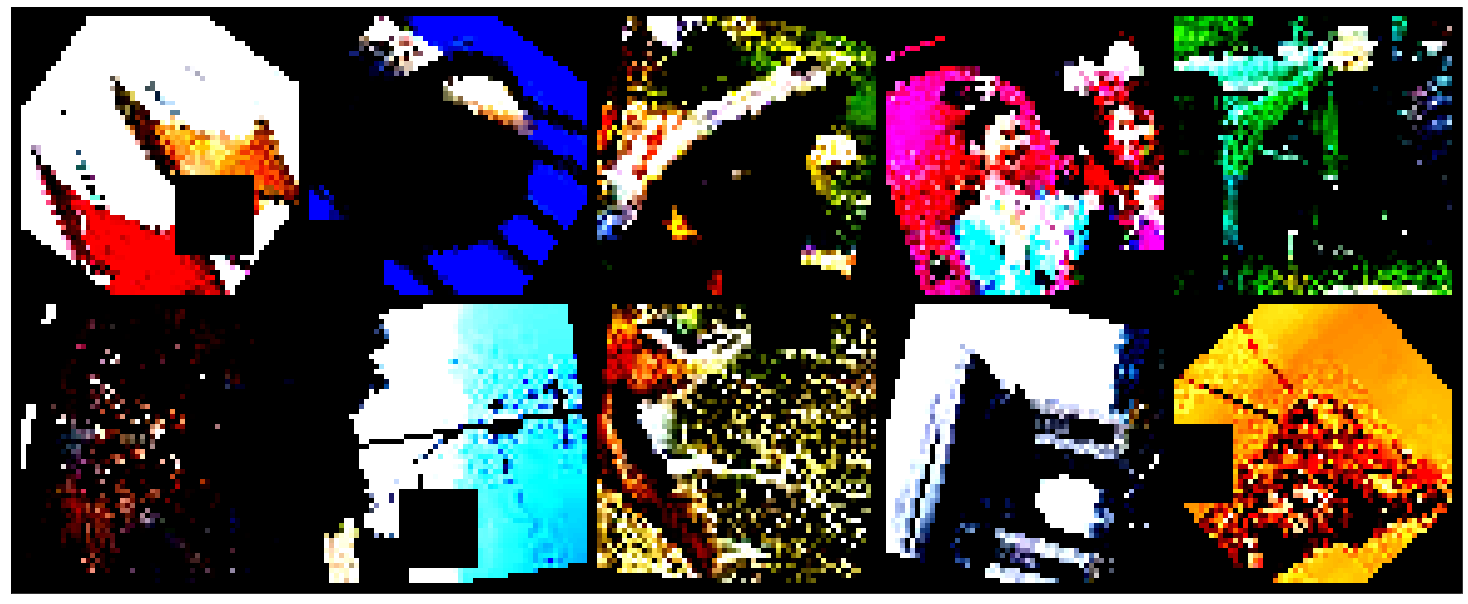

In [16]:
show_batch(train_dl)

print few Images from Test Data Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


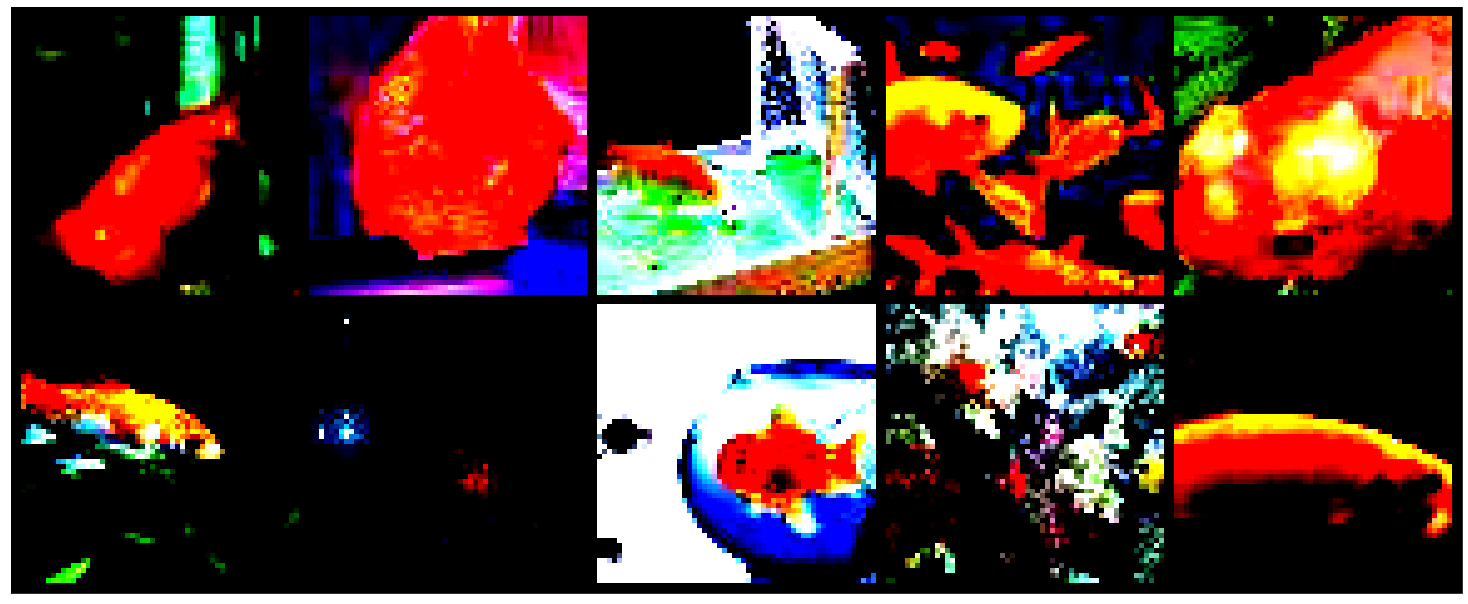

In [17]:
show_batch(test_dl)

# Test the model what we have written

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [19]:
import torchvision.models as models

model = models.resnet18()

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)

summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [20]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([512, 3, 56, 56])
out.shape: torch.Size([512, 200])


# Implementation of One cycle policy

In [21]:
!pip install torch-lr-finder -v --global-option="amp"

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-bhnyeqjc
Created temporary directory: /tmp/pip-req-tracker-648e_l3j
Created requirements tracker '/tmp/pip-req-tracker-648e_l3j'
Created temporary directory: /tmp/pip-install-u3zq1lam
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-648e_l3j'



Learning rate search finished. See the graph with {finder_name}.plot()


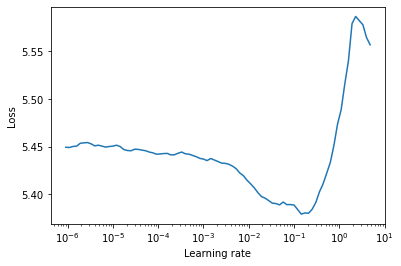

In [22]:
# LR range test
from torch_lr_finder import LRFinder
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, start_lr=1e-7,end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [23]:
print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print('so corresponding LR value at that index is--> LRmax : {}'.format(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]))
lrmax = lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]
lrmax = float('{:4f}'.format(lrmax))
print(lrmax)

Min loss value is : 5.3793914809001535 
Min LR value is   : 0.0000001445
Min loss observed at index : 75
so corresponding LR value at that index is--> LRmax : 0.1445439770745928
0.144544


In [0]:
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(optimizer, max_lr = lrmax, total_steps=50, epochs=
                       None, steps_per_epoch=None, pct_start=0.8, anneal_strategy='linear', 
                       cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10,final_div_factor=10)

In [0]:
trainaccuracies = []
trainlosses = []
vallosses = []
valaccuracies = []
misclassifieditems = []
lr_values = []

In [26]:
from lib import trainTestMethods
for epoch in range(1,26):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, 
                                     trainloader=train_dl, 
                                     device='cuda', 
                                     optimizer=optimizer, 
                                     criterion=criterion, 
                                     trainaccuracies=trainaccuracies, 
                                     trainlosses=trainlosses, 
                                     epoch=epoch)
    scheduler.step()
    testloss = trainTestMethods.testWithAccPlt(network=model, 
                                               testloader=test_dl, 
                                               device='cuda', 
                                               criterion=criterion, 
                                               valaccuracies=valaccuracies, 
                                               vallosses=vallosses, 
                                               epoch=epoch)


EPOCH: 1 LR: 0.014454400000000001

Epoch: 1
 [================================================================>]  Step: 56ms | Tot: 1m3s | Train >> Loss: 5.094 | Acc: 2.301% (1772/77000) 151/151 
 [================================================================>]  Step: 19ms | Tot: 12s995ms | Test >> Loss: 4.842 | Acc: 4.694% (1549/33000) 65/65 
0.009537222775545987

EPOCH: 2 LR: 0.01779003076923077

Epoch: 2
 [================================================================>]  Step: 56ms | Tot: 1m3s | Train >> Loss: 4.623 | Acc: 6.553% (5046/77000) 151/151 
 [================================================================>]  Step: 19ms | Tot: 12s919ms | Test >> Loss: 4.475 | Acc: 8.445% (2787/33000) 65/65 
0.008814892450968425

EPOCH: 3 LR: 0.02112566153846154

Epoch: 3
 [================================================================>]  Step: 55ms | Tot: 1m4s | Train >> Loss: 4.375 | Acc: 9.494% (7310/77000) 151/151 
 [=============================================================

In [27]:
from lib import trainTestMethods
for epoch in range(26,51):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, 
                                     trainloader=train_dl, 
                                     device='cuda', 
                                     optimizer=optimizer, 
                                     criterion=criterion, 
                                     trainaccuracies=trainaccuracies, 
                                     trainlosses=trainlosses, 
                                     epoch=epoch)
    scheduler.step()
    testloss = trainTestMethods.testWithAccPlt(network=model, 
                                               testloader=test_dl, 
                                               device='cuda', 
                                               criterion=criterion, 
                                               valaccuracies=valaccuracies, 
                                               vallosses=vallosses, 
                                               epoch=epoch)


EPOCH: 26 LR: 0.09784516923076925

Epoch: 26
 [================================================================>]  Step: 52ms | Tot: 1m5s | Train >> Loss: 2.679 | Acc: 35.701% (27490/77000) 151/151 
 [================================================================>]  Step: 19ms | Tot: 13s67ms | Test >> Loss: 3.231 | Acc: 28.636% (9450/33000) 65/65 
0.006363562558636521

EPOCH: 27 LR: 0.1011808

Epoch: 27
 [================================================================>]  Step: 54ms | Tot: 1m4s | Train >> Loss: 2.619 | Acc: 36.649% (28220/77000) 151/151 
 [================================================================>]  Step: 24ms | Tot: 12s938ms | Test >> Loss: 3.194 | Acc: 29.527% (9744/33000) 65/65 
0.006292102651162581

EPOCH: 28 LR: 0.10451643076923077

Epoch: 28
 [================================================================>]  Step: 57ms | Tot: 1m8s | Train >> Loss: 2.578 | Acc: 37.313% (28731/77000) 151/151 
 [===========================================================

# Plot Metrics - Accuracy and Loss

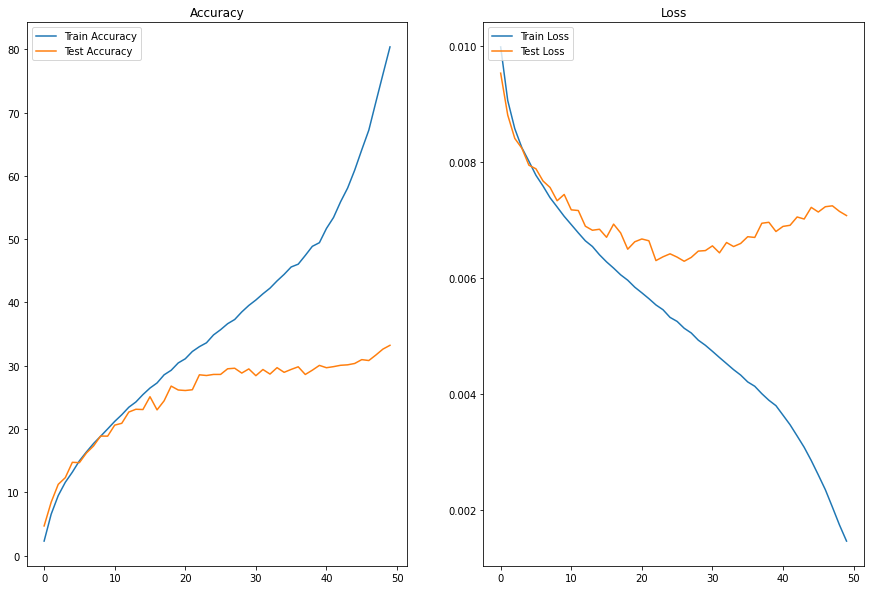

Max. Train Accuracy outoff 50-epochs is : 80.38441558441558 at 50-Epoach
Max. Test Accuracy  outoff 50-epochs is : 33.236363636363635 at 50-Epoach


Min. Train Loss outoff 50-epochs is : 0.001465 at 50-Epoach
Min. Test Loss  outoff 50-epochs is : 0.006292 at 27-Epoach


Target-50.0% achieved at 41th epoach,Train accuracy is : 51.701298701298704


In [28]:
trainTestMethods.plotmetrics(50,
                             trainaccuracies=trainaccuracies, 
                             testaccuracies=valaccuracies, 
                             trainlosses=trainlosses, 
                             testlosses=vallosses, 
                             savefilename="metrics")

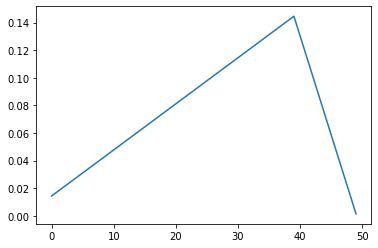

In [29]:
plt.plot(lr_values)